In [4]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
import tensorflow.keras as keras
import sys
sys.modules['keras'] = keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [7]:
df=pd.read_csv('/content/drive/MyDrive/Twitter_training_sentiment.csv',encoding='ISO-8859-1')
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


# Show all columns

In [8]:
df.keys()

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

# Change column's name

In [9]:
df=df.rename(columns={"0": "target", "Mon Apr 06 22:19:45 PDT 2009": "Date","1467810369":"ids",
                      "_TheSpecialOne_":"Source","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D":"text"})

In [10]:
df

,target,ids,Date,NO_QUERY,Source,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


# Drop id columns

In [11]:
df=df.drop(columns = ['ids'])

In [12]:
df

,target,Date,NO_QUERY,Source,text
0,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...
1599994,4,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


# Count the number of Null

In [13]:
df.isna().sum()

target      0
Date        0
NO_QUERY    0
Source      0
text        0
dtype: int64

# Unique column

In [14]:
df.nunique()

target            2
Date         774362
NO_QUERY          1
Source       659775
text        1581465
dtype: int64

# Review data parameters

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   target    1599999 non-null  int64 
 1   Date      1599999 non-null  object
 2   NO_QUERY  1599999 non-null  object
 3   Source    1599999 non-null  object
 4   text      1599999 non-null  object
dtypes: int64(1), object(4)
memory usage: 61.0+ MB


# Output csv and excel file

In [16]:
df.to_csv("Twitter_sentiment.csv",index= False)
#with pd.ExcelWriter('Twitter_sentiment.xlsx', engine='xlsxwriter') as writer:
    #df_new.to_excel(writer, sheet_name='Twitter_sentiment_training_data', index=False)

In [17]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [18]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 617 ms, sys: 6.56 ms, total: 624 ms
Wall time: 632 ms


# Stop words are used to save storage space and improve search efficiency. Certain words or words are automatically filtered out when processing text.

In [21]:
stop_words = stopwords.words("english") #這裡設定稍後取用 English 的停用詞語料庫
stemmer = SnowballStemmer("english")

In [22]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [23]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [24]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 59.2 s, sys: 372 ms, total: 59.6 s
Wall time: 1min


# Spilt trainset and testset

In [25]:
TRAIN_SIZE=0.8
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1279999
TEST size: 320000


In [26]:
type(df_train)

pandas.core.frame.DataFrame

In [27]:
#%%time
documents = [_text.split() for _text in df_train.text] 

# Word2Vec-find the vector of embedding

In [28]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [29]:
w2v_model.build_vocab(documents)

In [30]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 24min 30s, sys: 7.8 s, total: 24min 38s
Wall time: 12min 54s


(263117899, 295311488)

# Tokenize Text- data retrieval

In [31]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290442
CPU times: user 19.5 s, sys: 147 ms, total: 19.6 s
Wall time: 19.6 s


In [32]:
%%time
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 25.7 s, sys: 746 ms, total: 26.4 s
Wall time: 26.4 s


In [33]:
NEUTRAL = "NEUTRAL"

labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [34]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1279999, 1)
y_test (320000, 1)


In [35]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1279999, 300)
y_train (1279999, 1)

x_test (320000, 300)
y_test (320000, 1)


In [36]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

# embedding

In [37]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290442, 300)


In [38]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Build model

In [39]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87132600  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,293,101
Trainable params: 160,501
Non-trainable params: 87,132,600
_________________________________________________________________


In [40]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [41]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [42]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 1699s 2s/step - loss: 0.5038 - accuracy: 0.7505 - val_loss: 0.4702 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - 1709s 2s/step - loss: 0.4785 - accuracy: 0.7676 - val_loss: 0.4615 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - 1704s 2s/step - loss: 0.4717 - accuracy: 0.7721 - val_loss: 0.4559 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - 1680s 1s/step - loss: 0.4708 - accuracy: 0.7727 - val_loss: 0.4533 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - 1704s 2s/step - loss: 0.4659 - accuracy: 0.7756 - val_loss: 0.4500 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - 1715s 2s/step - loss: 0.4636 - accuracy: 0.7771 - val_loss: 0.4489 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================]

# Save epoch

In [43]:
model.save('epoch_8'+'.h5')

# Evaluate model- use testdet

In [44]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 74s 236ms/step - loss: 0.4470 - accuracy: 0.7910

ACCURACY: 0.7909500002861023
LOSS: 0.4469797909259796
CPU times: user 50.5 s, sys: 18.2 s, total: 1min 8s
Wall time: 1min 14s


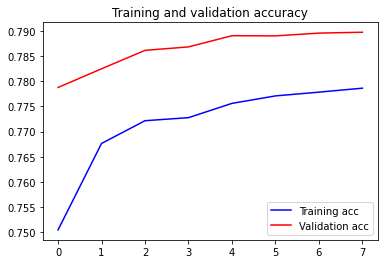

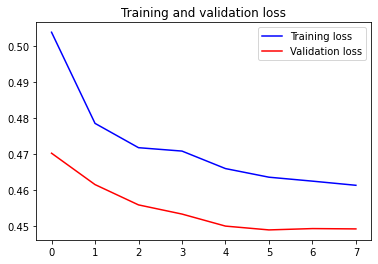

In [45]:
acc = history.history["accuracy"]
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
 
plt.show()

# Predict model for future texts

In [46]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

def decode_sentiment2(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

# The funtion use to predict all texts

In [58]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment2(score, include_neutral=include_neutral)
    return label 

In [59]:
df_pre=pd.read_csv('/content/drive/MyDrive/testdata.manual.2009.06.14.csv',encoding='ISO-8859-1')
df_pre

,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
0,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
3,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
4,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...
...,...,...,...,...,...,...
492,2,14072,Sun Jun 14 04:31:43 UTC 2009,latex,proggit,Ask Programming: LaTeX or InDesign?: submitted...
493,0,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
494,4,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
495,0,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [60]:
df_pre=df_pre.rename(columns={"4": "target", "Mon May 11 03:17:40 UTC 2009": "Date","3":"ids",
                      "kindle2":"Source","@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.":"text","tpryan":"User"})

In [61]:
df_pre

,target,ids,Date,Source,User,text
0,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
3,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
4,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...
...,...,...,...,...,...,...
492,2,14072,Sun Jun 14 04:31:43 UTC 2009,latex,proggit,Ask Programming: LaTeX or InDesign?: submitted...
493,0,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
494,4,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
495,0,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [62]:
df_pre.target = df_pre.target.apply(lambda x: decode_sentiment(x))

In [63]:
df_pre.text = df_pre.text.apply(lambda x: preprocess(x))

In [64]:
def score(df_pre):
    length = len(df_pre.target)
    tmp = 0
    for i in range(length):
        label = predict(df_pre.text[i])
        if label == df_pre.target[i]:
            tmp = tmp + 1
    return tmp/length        

In [65]:
score_pre = score(df_pre)
print("The score is ", score_pre)

The score is  0.6177062374245473


In [66]:
predict("I love the music")

'POSITIVE'

In [67]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment2(score, include_neutral=False) for score in scores]

40/40 [==============================] - 49s 1s/step
CPU times: user 27.6 s, sys: 20.3 s, total: 47.9 s
Wall time: 50 s


# confusion_matrix

In [68]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

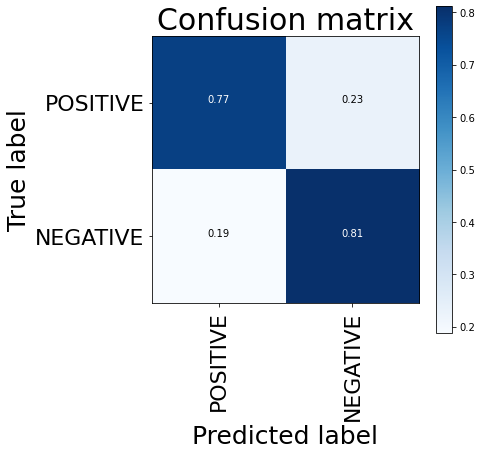

CPU times: user 1.37 s, sys: 14.6 ms, total: 1.39 s
Wall time: 1.39 s


In [69]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [70]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.77      0.79    159494
    POSITIVE       0.78      0.81      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [71]:
accuracy_score(y_test_1d, y_pred_1d)

0.79095

# Data visualization

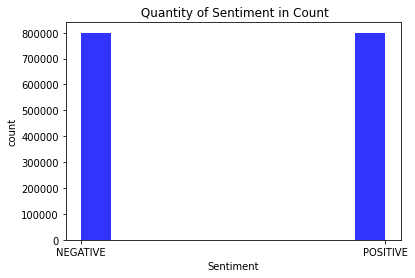

In [72]:
plt.hist(df['target'], bins=10, color='b',alpha=0.8,rwidth=10)
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.title(' Quantity of Sentiment in Count')
plt.show()